검출된 키포인트 개수: 1071
디스크립터 shape: (1050, 8)


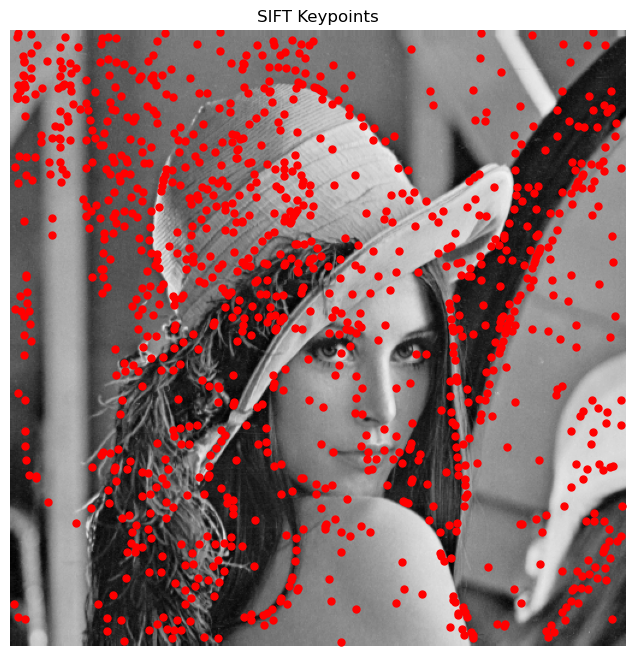

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2  # OpenCV를 사용해 이미지 로드

# 1. 이미지 로드 (OpenCV 사용)
# 이미지 경로를 지정하세요 (예: 'image.jpg')
image_path = './image/lena.bmp'  # 실제 이미지 경로로 변경 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 그레이스케일로 로드

# 이미지가 제대로 로드되었는지 확인
if image is None:
    print("이미지를 로드할 수 없습니다. 경로를 확인하세요.")
    exit()

# OpenCV는 uint8 타입으로 이미지를 로드하므로 float32로 변환
image = image.astype(np.float32)

# 2. 스케일 스페이스 피라미드 생성
def build_gaussian_pyramid(image, num_octaves=4, num_scales=3, sigma=1.6):
    pyramid = []
    k = 2 ** (1.0 / num_scales)  # 스케일 간 sigma 증가 비율
    
    for octave in range(num_octaves):
        octave_images = []
        current_image = image.copy()
        
        # 첫 번째 옥타브에서는 원본 이미지 사용, 이후에는 다운샘플링
        if octave > 0:
            current_image = current_image[::2, ::2]  # 다운샘플링 (1/2 크기)
        
        # 각 스케일에 대해 가우시안 블러 적용
        for scale in range(num_scales + 3):  # 추가 스케일 포함
            sigma_current = sigma * (k ** scale)
            blurred = gaussian_filter(current_image, sigma=sigma_current)
            octave_images.append(blurred)
        
        pyramid.append(octave_images)
        image = current_image  # 다음 옥타브를 위해 이미지 업데이트
    
    return pyramid

# 3. DoG(Difference of Gaussian) 피라미드 생성
def build_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    
    for octave in gaussian_pyramid:
        dog_octave = []
        for i in range(len(octave) - 1):
            dog = octave[i + 1] - octave[i]
            dog_octave.append(dog)
        dog_pyramid.append(dog_octave)
    
    return dog_pyramid

# 4. 키포인트 검출 (극값 찾기)
def detect_keypoints(dog_pyramid, threshold=0.03):
    keypoints = []
    
    for octave_idx, dog_octave in enumerate(dog_pyramid):
        for scale_idx in range(1, len(dog_octave) - 1):  # 첫 번째와 마지막 스케일 제외
            current = dog_octave[scale_idx]
            prev = dog_octave[scale_idx - 1]
            next = dog_octave[scale_idx + 1]
            
            h, w = current.shape
            for y in range(1, h - 1):
                for x in range(1, w - 1):
                    # 3x3x3 이웃에서 극값인지 확인
                    patch = np.array([
                        prev[y-1:y+2, x-1:x+2],  # 이전 스케일
                        current[y-1:y+2, x-1:x+2],  # 현재 스케일
                        next[y-1:y+2, x-1:x+2]    # 다음 스케일
                    ])
                    center = current[y, x]
                    
                    # 극값 조건: 중심값이 이웃 26개 값보다 크거나 작아야 함
                    if (center > threshold and np.all(center >= patch) and np.all(center > 0)) or \
                       (center < -threshold and np.all(center <= patch) and np.all(center < 0)):
                        # 키포인트: (옥타브, 스케일, y, x)
                        keypoints.append((octave_idx, scale_idx, y, x))
    
    return keypoints

# 5. 방향 할당
def assign_orientations(image, keypoints, sigma=1.6):
    orientations = []
    
    for octave_idx, scale_idx, y, x in keypoints:
        # 해당 옥타브의 이미지 가져오기
        scale_factor = 2 ** octave_idx
        y_scaled, x_scaled = int(y * scale_factor), int(x * scale_factor)
        
        # 가우시안 블러 적용
        blurred = gaussian_filter(image, sigma=sigma)
        
        # 그래디언트 계산
        dy = blurred[y_scaled + 1, x_scaled] - blurred[y_scaled - 1, x_scaled]
        dx = blurred[y_scaled, x_scaled + 1] - blurred[y_scaled, x_scaled - 1]
        magnitude = np.sqrt(dx**2 + dy**2)
        orientation = np.arctan2(dy, dx) * 180 / np.pi  # 라디안을 도로 변환
        
        orientations.append((octave_idx, scale_idx, y, x, orientation))
    
    return orientations

# 6. 디스크립터 생성 (간단화된 버전)
def compute_descriptors(image, keypoints_with_orientations, patch_size=16):
    descriptors = []
    
    for octave_idx, scale_idx, y, x, orientation in keypoints_with_orientations:
        # 해당 위치에서 패치 추출
        scale_factor = 2 ** octave_idx
        y_scaled, x_scaled = int(y * scale_factor), int(x * scale_factor)
        
        # 패치 크기 설정
        half_patch = patch_size // 2
        patch = image[max(0, y_scaled - half_patch):y_scaled + half_patch,
                      max(0, x_scaled - half_patch):x_scaled + half_patch]
        
        if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
            continue
        
        # 그래디언트 계산
        dy, dx = np.gradient(patch)
        magnitude = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx) * 180 / np.pi
        
        # 방향 히스토그램 생성 (간단화: 8방향)
        hist, _ = np.histogram(angle, bins=8, range=(-180, 180), weights=magnitude)
        
        # 정규화
        hist = hist / (np.linalg.norm(hist) + 1e-6)
        descriptors.append(hist)
    
    return np.array(descriptors)

# 메인 실행
# 1. 가우시안 피라미드 생성
gaussian_pyramid = build_gaussian_pyramid(image)

# 2. DoG 피라미드 생성
dog_pyramid = build_dog_pyramid(gaussian_pyramid)

# 3. 키포인트 검출
keypoints = detect_keypoints(dog_pyramid)

# 4. 방향 할당
keypoints_with_orientations = assign_orientations(image, keypoints)

# 5. 디스크립터 생성
descriptors = compute_descriptors(image, keypoints_with_orientations)

# 결과 출력
print(f"검출된 키포인트 개수: {len(keypoints)}")
print(f"디스크립터 shape: {descriptors.shape}")

# 키포인트 시각화 (Matplotlib 사용)
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')  # 그레이스케일 이미지 표시
for _, _, y, x, _ in keypoints_with_orientations:
    plt.plot(x, y, 'ro', markersize=5)  # 키포인트를 빨간 점으로 표시
plt.title('SIFT Keypoints')
plt.axis('off')  # 축 숨기기
plt.show()